# Project: "Multi-class image classification on the Fruits-360 dataset using convolutional neural networks (using TensorFlow, Keras) and Vision Transformers (using PyTorch)."

# Data Source: Fruits-360-dataset (https://www.kaggle.com/datasets/moltean/fruits)

In [ ]:
# import libraries
import keras
from keras import layers,callbacks
from keras import models,Input
from keras.datasets import mnist
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
from numpy.random.mtrand import shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import zipfile

In [ ]:
# kaggle API set up by downloading kaggle.json
# clear output to make kaggle key not show in the output
from google.colab import files
files.upload()

In [ ]:
# After uploading kaggle.json to Colab...
#!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the data from Kaggle "fruits-360" dataset
!kaggle datasets download -d moltean/fruits

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
 98% 4.70G/4.78G [00:17<00:00, 166MB/s] 
100% 4.78G/4.78G [00:17<00:00, 296MB/s]


In [ ]:
# Making sure all necessary files in /Content directory
print(os.listdir('/content'))

['.config', 'kaggle.json', 'fruits.zip', 'sample_data']


In [ ]:
# Build dataset fruits-360_100x100 from that folder files only.

zip_path = '/content/fruits.zip'
extract_folder = '/content/'

if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    files_to_extract = [f for f in zip_ref.namelist() if f.startswith('fruits-360_100x100/')]
    for file in files_to_extract:
        zip_ref.extract(file, extract_folder)

Load image from: /content/fruits-360_100x100/fruits-360/Training/Apple 10/r0_0_100.jpg


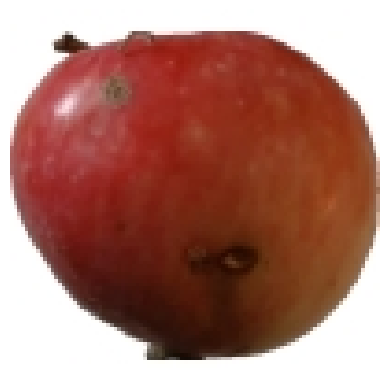

In [ ]:
# Check one of the image as part of Exploratory Data Analysis!

base_path       = '/content/fruits-360_100x100/fruits-360'
training_path   = os.path.join(base_path, 'Training')
image_path      = os.path.join(training_path, 'Apple 10/r0_0_100.jpg')

print(f"Load image from: {image_path}")
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
#Create Training/Validation/Test Datasets!
# Using TensorFlow's image_dataset_from_directory to create the Training and Test dataset

train_dir = '/content/fruits-360_100x100/fruits-360/Training'
test_dir = '/content/fruits-360_100x100/fruits-360/Test'

AUTOTUNE = tf.data.AUTOTUNE # Adding performance optimizations to speed the training!

# Normalize pixel values (equivalent to rescale=1./255)
def normalize(image, label):
    return image / 255.0, label

# Training and validation datasets are complimentary subsets of training directory
# Validation dataset is 20% training data
val_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=43,
    image_size=(100, 100),
    batch_size=32,
    label_mode='int' # integer labels (0-231) for 232 classes!
).map(normalize).cache().prefetch(AUTOTUNE)

# Training dataset 80% of training data.
train_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=43,
    image_size=(100, 100),
    batch_size=32,
    label_mode='int',
    shuffle=True, # random order for training!
).map(normalize).cache().shuffle(1000).prefetch(AUTOTUNE)

# this will be used for final evaluation
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(100, 100),
    batch_size=32,
    label_mode='int',
    shuffle=False,    # no need to shuffle test data, for unbiased final evaluation.
).map(normalize).cache().prefetch(AUTOTUNE)

Found 122118 files belonging to 232 classes.
Using 24423 files for validation.
Found 122118 files belonging to 232 classes.
Using 97695 files for training.
Found 40715 files belonging to 232 classes.


In [ ]:
print(f"Train batches: {len(train_dataset)}") # 3053*32 ~ 97696 training files!
print(f"Val batches: {len(val_dataset)}")     # 764*32 ~ 24448 validation files
print(f"Test batches: {len(test_dataset)}")   # 1273*32 ~40736 testing files

Train batches: 3053
Val batches: 764
Test batches: 1273


In [ ]:
# Sort for alphabetical order and verify it should be 232 classes!
class_names = sorted(os.listdir(train_dir))
print(f"Classes found: {len(class_names)}")

Classes found: 232


In [ ]:
# the output yields batches of 100x100 images (shape (32, 100, 100, 3)) and labels (shape (32,)). 32 is the number of samples in each batch (the batch size).

for data_batch, labels_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

# 32 images per batch, 100×100 pixels, 3 RGB channels
# 32 integer labels (0-231 for 232 classes)

data batch shape: (32, 100, 100, 3)
labels batch shape: (32,)


**The data pipeline is setup for Fruits-360 and next steps are building models/train/evaluate - baseline CNN, enhanced CNN, and Vision Transformer.**

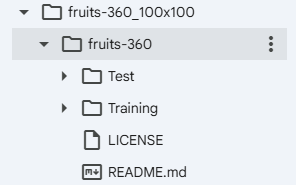


In [ ]:
# simple baseline CNN

model = models.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(232, activation='softmax')  # 232 classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', #sparse_categorical_crossentropy because 232 classes!
    metrics=['accuracy'],
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,225,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 232)            │        29,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,348,648 (28.03 MB)

 Trainable params: 7,348,648 (28.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)

Epoch 1/10
3053/3053 ━━━━━━━━━━━━━━━━━━━━ 48s 13ms/step - accuracy: 0.3225 - loss: 2.9223 - val_accuracy: 0.9533 - val_loss: 0.1628
Epoch 2/10
3053/3053 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.7542 - loss: 0.7447 - val_accuracy: 0.9785 - val_loss: 0.0641
Epoch 3/10
3053/3053 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.8367 - loss: 0.4885 - val_accuracy: 0.9855 - val_loss: 0.0406
Epoch 4/10
3053/3053 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.8823 - loss: 0.3508 - val_accuracy: 0.9939 - val_loss: 0.0173
Epoch 5/10
3053/3053 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9099 - loss: 0.2706 - val_accuracy: 0.9958 - val_loss: 0.0124
Epoch 6/10
3053/3053 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9282 - loss: 0.2148 - val_accuracy: 0.9951 - val_loss: 0.0127
Epoch 7/10
3053/3053 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9424 - loss: 0.1766 - val_accuracy: 0.9954 - val_loss: 0.0140
Epoch 8/10
3053/3053 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9478 - loss: 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

1273/1273 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9740 - loss: 0.1610
Test Accuracy: 0.9724


# **The baseline CNN shows impressive results with the Testing Accuracy of ~97.24 % accuracy.**

In [ ]:
# Enhancing the baseline CNN
#Reference: https://saturncloud.io/blog/understanding-the-difference-between-flatten-and-globalaveragepooling2d-in-keras/

# Data augmentation
# Small rotations, horizontal flips, zoom, and contrast/brightness to help generalization.
# Avoiding heavy transformations that distort the fruit too much.
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

model = models.Sequential([
    data_augmentation,
    layers.Conv2D(32, 3, activation='relu', input_shape=(100, 100, 3), kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
    layers.GlobalAveragePooling2D(), # reduces parameters compare to flatten, prevents overfitting.
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
    layers.Dropout(0.2), # Experiment 50% dropout rate and reduce to 20%
    layers.Dense(232, activation='softmax')  # 232 classes
])

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode = 'max'),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True, mode = 'max', verbose = 1),
    ReduceLROnPlateau(factor=0.5, patience=3) # Experimenting on Reducing the learning rate when validation accuracy stops improving.
]

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', #sparse_categorical_crossentropy because 232 classes!
    metrics=['accuracy'],
)

# dummy input to build the model!
model.build(input_shape=(None, 100, 100, 3))
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 232)            │        29,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,688 (545.66 KB)

 Trainable params: 139,688 (545.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)

In [ ]:
# saving best model and verifying the Best Model Test Accuracy!
best_model = tf.keras.models.load_model('best_model.keras')
final_test_loss, final_test_acc = best_model.evaluate(test_dataset)
print(f"Best Model Test Accuracy: {final_test_acc:.4f}")

1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9488 - loss: 0.2752
Best Model Test Accuracy: 0.9482


# Testing Accuracy for Enhanced CNN is 94.82%.

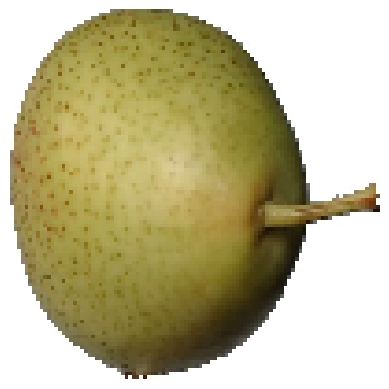

In [ ]:
# Testing Random Pear Fruit Image downloaded from the Internet using the classifier.

img_path = '/content/Pear_Fruit_RandomTestImage.jpg'
img = keras.utils.load_img(img_path, target_size=(100, 100))
img_array = keras.utils.img_to_array(img)
img_array = img_array / 255.0 # rescaling!

plt.imshow(img_array)
plt.axis('off')
plt.show()

In [ ]:
# Prediction on the image!
img_batch = np.expand_dims(img_array, axis=0)
print(img_batch.shape)

pred_probs = best_model.predict(img_batch)
pred_class_idx = np.argmax(pred_probs[0]) # index of class - highest probability!

pred_conf = pred_probs[0][pred_class_idx]
pred_class_name = class_names[pred_class_idx]

print('*****************************************')
print(f"Predicted: {pred_class_name}")
print(f"Confidence: {pred_conf:.3f}")
print('*****************************************')


(1, 100, 100, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
*****************************************
Predicted: Pear 1
Confidence: 0.998
*****************************************


In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


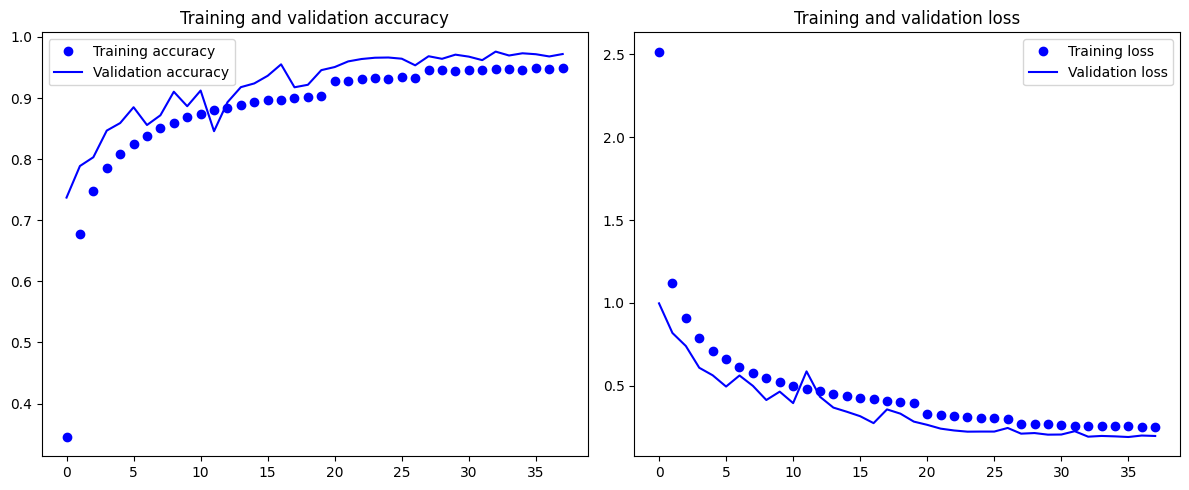

In [ ]:
# Plot the accuracy and loss of the enhanced CNN model for training and validation data during training

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(epochs, acc, 'bo', label='Training accuracy')
axes[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
axes[0].set_title('Training and validation accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].set_title('Training and validation loss')
axes[1].legend()

plt.tight_layout()
plt.show()

## The Testing Accuracy for the enhanced CNN is ~94.82% - that's good for the full 232-class Fruits-360 dataset BUT the baseline CNN performed better. Adding data augmentation, regularization, dropouts is theoritically stronger model AND the results still show great generalized model - that has learned well without overfitting!

# Implementing Vision Transformer (ViT) using PyTorch
References:

https://arxiv.org/abs/2010.11929

https://medium.com/correll-lab/building-a-vision-transformer-model-from-scratch-a3054f707cc6

https://viso.ai/deep-learning/vision-transformer-vit/

https://www.geeksforgeeks.org/deep-learning/building-a-vision-transformer-from-scratch-in-pytorch/

https://github.com/nerminnuraydogan/vision-transformer


# **Vision Transformer Architecture**

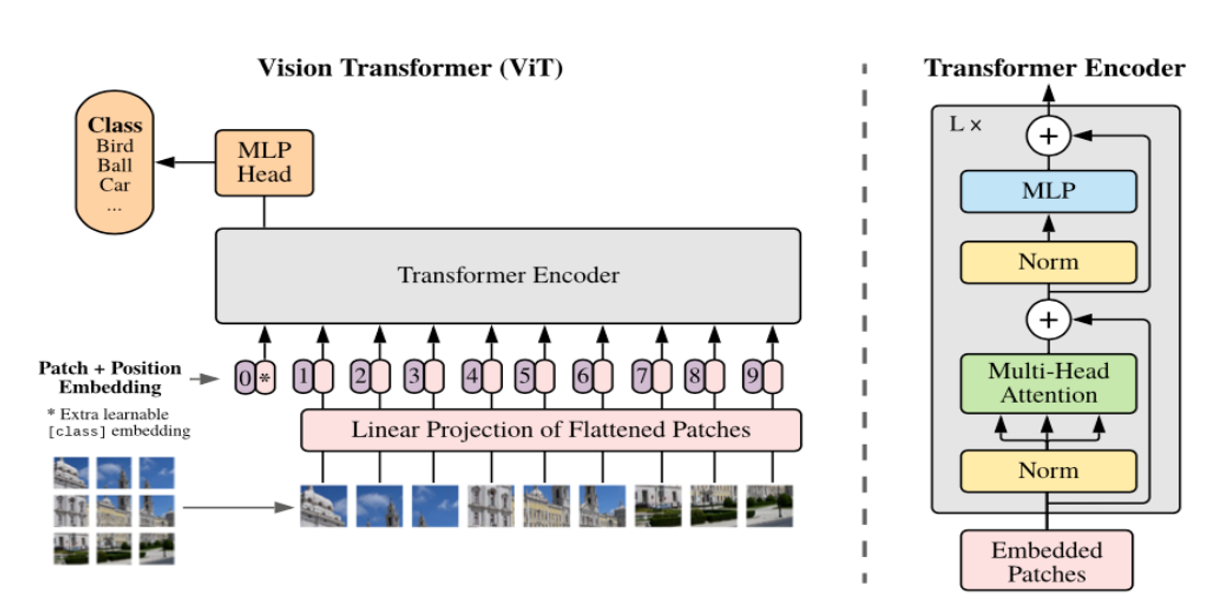

Source: https://github.com/google-research/vision_transformer

In [ ]:
# Step 1: Set up, leveraging existing data pipeline.
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Fruits-360 folders (100x100 → 96x96 for 12x12 patches with patch_size = 12)
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # ViT architecture designed for [-1,1] vs CNN usd /255.0!
])

train_data = datasets.ImageFolder(root='/content/fruits-360_100x100/fruits-360/Training', transform=transform)
test_data = datasets.ImageFolder(root='/content/fruits-360_100x100/fruits-360/Test', transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

num_classes = len(train_data.classes) #232
print(num_classes)


232


In [ ]:
# Step 2: PatchEmbedding - Image to non-overlapping patches and embed in lower-dim (1D) space!

#Divide an image (96x96) into fixed-size patches (8x8) = 144 patches.
#Each patch is flattened into a vector and embedded with linear projection.
# in_chans = 3, input channels for RGB - Red, Green, Blue
# embed_dim = 192 output dimension for each patch.

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=8, in_chans=3, embed_dim=192):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

     # 2D image into sequence of 1D tranformer tokens!
    def forward(self, x):
        B = x.shape[0]                                # Batch size
        x = self.proj(x).flatten(2).transpose(1, 2)   # flatten and transpose to 1D sequence like words in NLP
        cls_tokens = self.cls_token.expand(B, -1, -1) # special token for classification like CLS in BERT
        x = torch.cat((cls_tokens, x), dim=1)         # 1 cls + 144 patches
        return x


In [ ]:
# Step 3: Transformer Block
# LayerNorm -> Multi-Head Self Attention->Residual Add
# LayerNorm -> MLP (two linear layer with GELU, dropout) ->Residual Add


# Transformer Block - Multi-head self-attention layer, followed by feed-forward network and residual connections.
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=192, num_heads=6, mlp_ratio=4.0, drop=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(drop)
            )

    def forward(self, x):
        # Attention
        attn_out, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + attn_out
        #MLP
        x = x + self.mlp(self.norm2(x))
        return x

In [ ]:
# Step 4 Vision Transformer (ViT) Model

# stack the transformer blocks to build the baseline Vision Transformer Model.

class ViT(nn.Module):
  def __init__(self, img_size = 96, patch_size = 8, in_chans=3, embed_dim=192, depth = 6, num_heads=6, mlp_ratio=4.0, num_classes=232, drop=0.1):
    super().__init__()
    self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
    self.pos_embed   = nn.Parameter(torch.zeros(1,1+(img_size//patch_size)**2, embed_dim)) # positional embedding for spatial relationships
    self.blocks = nn.ModuleList([
        TransformerBlock(embed_dim, num_heads, mlp_ratio, drop)
        for _ in range(depth)
        ])
    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)

  def forward(self, x):
    x = self.patch_embed(x)
    x = x + self.pos_embed
    for block in self.blocks:
      x = block(x)
    x = self.norm(x)
    cls_token = x[:, 0]
    return self.head(cls_token)

In [ ]:
# Training

# Reference: https://stackoverflow.com/questions/66443620/how-to-find-training-accuracy-in-pytorch

device = "cuda" if torch.cuda.is_available() else 'cpu'
model = ViT(num_classes=num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss() # Creating Loss Function.

num_epochs = 15
train_losses = []
train_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
      imgs, labels = imgs.to(device), labels.to(device)
      optimizer.zero_grad()

      outputs = model(imgs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Training accuracy and loss calculations

      _, preds = torch.max(outputs, dim=1) # predicted class indexes
      correct += (preds == labels).sum().item()
      train_loss += loss.item() * imgs.size(0) # img_size(0) is the batch size, this gives sum of losses over all samples
      total += labels.size(0)

      epoch_loss = train_loss / total
      epoch_acc = correct / total

    # record for each epoch training loss and accuracy for the plotting!
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f}")

Epoch 1, Train Loss: 0.7675 Train Acc: 0.7893
Epoch 2, Train Loss: 0.1446 Train Acc: 0.9506
Epoch 3, Train Loss: 0.1101 Train Acc: 0.9628
Epoch 4, Train Loss: 0.0866 Train Acc: 0.9699
Epoch 5, Train Loss: 0.0671 Train Acc: 0.9770
Epoch 6, Train Loss: 0.0628 Train Acc: 0.9786
Epoch 7, Train Loss: 0.0522 Train Acc: 0.9830
Epoch 8, Train Loss: 0.0472 Train Acc: 0.9844
Epoch 9, Train Loss: 0.0414 Train Acc: 0.9864
Epoch 10, Train Loss: 0.0396 Train Acc: 0.9871
Epoch 11, Train Loss: 0.0325 Train Acc: 0.9894
Epoch 12, Train Loss: 0.0367 Train Acc: 0.9885
Epoch 13, Train Loss: 0.0292 Train Acc: 0.9908
Epoch 14, Train Loss: 0.0251 Train Acc: 0.9922
Epoch 15, Train Loss: 0.0254 Train Acc: 0.9920


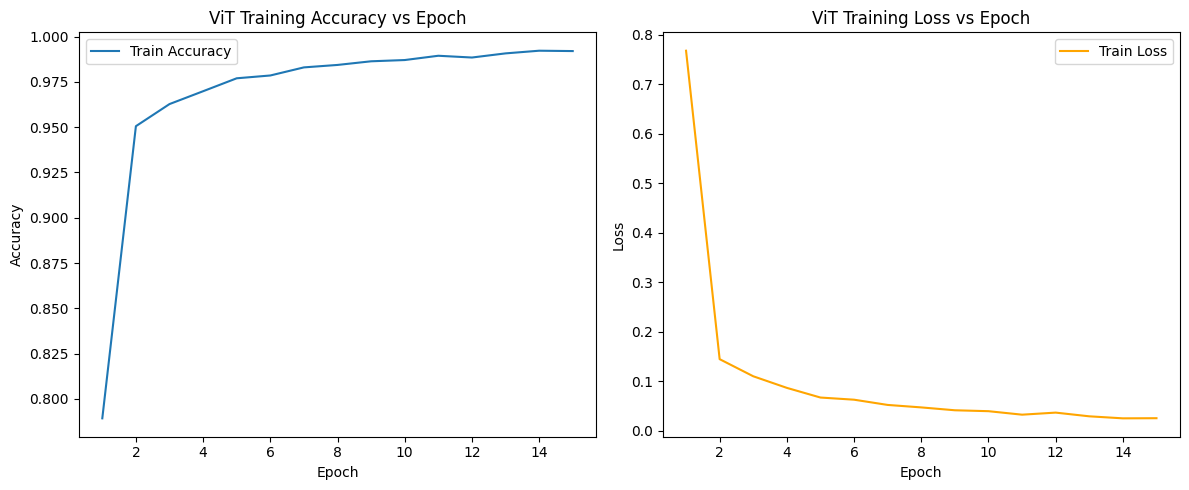

In [ ]:
# plot training loss/accuracies.
# For basic proof of concept for ViT, validation split was not done, so can't comment if model is generalized
# In this case, test dataset should give good idea on performance.

epochs_range = range(1, num_epochs + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs_range, train_accuracies, label='Train Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('ViT Training Accuracy vs Epoch')
ax1.legend()

ax2.plot(epochs_range, train_losses, label='Train Loss', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('ViT Training Loss vs Epoch')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Testing Model against test dataset images

# Evaluation - PyTorch doesn't have convinient model.evaluate function to run on test dataset
# Reference: https://pythonguides.com/pytorch-model-eval/

def evaluate_model(model, test_loader, device):
    model.eval()  # Set to evaluation mode (disables dropout)
    test_loss = 0
    correct = 0
    total = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # No gradients = faster + less memory
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, preds = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    avg_loss = test_loss / total
    accuracy = (correct / total)*100

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}% ({correct}/{total})")
    return avg_loss, accuracy

# Run Evaluation
final_test_loss, final_test_acc = evaluate_model(model, test_loader, device)

Test Loss: 0.0008, Test Accuracy: 98.5951% (40143/40715)


# ***Test Accuracy: 98.6% !!!***

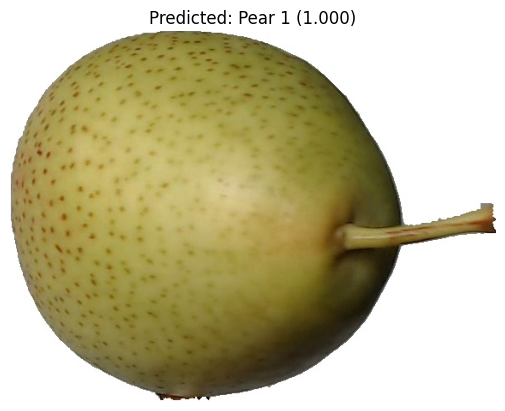

In [ ]:
# And also sanity check with same Pear fruit image used earlier

# Load and preprocess your image
from PIL import Image
img = Image.open('/content/Pear_Fruit_RandomTestImage.jpg')
img_tensor = transform(img).unsqueeze(0).to(device)  # (1, 3, 96, 96)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(img_tensor)
    probs = torch.nn.functional.softmax(outputs, dim=1)
    pred_class_idx = torch.argmax(probs, dim=1).item()
    pred_conf = probs.max().item()

pred_class_name = class_names[pred_class_idx]

# Show original image (before transform) And print prediction with
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {pred_class_name} ({pred_conf:.3f})")
plt.show()

And it predicts correctly Pear with 100% confidence!

# With baseline Vision Transformer Test Accuracy is ~ 98%!